This code is designed to calibrate my motion tracking glove, which records joint angles but in arbitrary units; the arbitrary units linearly map to the actual joint angles, but the exact line varies by subject. So the objective here is to map the glove measurements to "ground truth" joint angles recorded simultaneously.

This `v0` notebook _resembles_ some actual code Alfred wrote for me, and he has generously volunteered to be personally victimized by yours truly for pedagogical purposes. "Resembles" means that I've already made some changes to (a) remove code we're not going to talk about today, (b) moved some code blocks around to a better order for presentation, and (c) made some fixes that are easier to illustrate side-by-side than by creating a new "version" of the code, as I will for more substantive changes. 

In [1]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from collections import OrderedDict
from re import findall
import pandas as pd
import numpy as np 
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from bids import BIDSLayout

Okay, first major comment. The directories for the data files were originally specified as follows:

```
#base directory
bdir = r'C:\\Users\\Alfred\\Desktop\\ENL\\John\\'
#data directory
ddir = f"{bdir}\\data\\"
```

Obviously, these filepaths will only work on Alfred's machine, since they're absolute filepaths. It would be better to use relative filepaths (i.e. relative to the working directory, which is by default the folder you're running your code from). So in this case, the following would have been sufficient (and would work on all machines):

```
ddir = 'data'
```

If you _do_ need to access a nested directory, you shouldn't use "joiners" `\`, `\\`, or `/` directly, as these are all operating system specific. So instead of:
```
ddir = f"{bdir}\\data\\"
```
it would be better to use:
```
ddir = os.path.join(bdir, 'data')
```

assuming `bdir` is a valid path. `os.path.join` will always use the appropriate joiner for the current operating system.

And, of course, if you hard-code any filepaths (or hard-code anything else important), please be so kind as to put them near the top of your script/notebook AND IN ALL CAPS, so they're easy to find if they need to be changed. 

In [2]:
DATA_DIR = 'bids_pilot'
SUBJECT = '01'

But we actually won't be using any of the above methods to find filepaths. Since Alfred wrote his code, I organized the data into a [Brain Imaging Data Structure](https://bids-specification.readthedocs.io/en/stable/modality-specific-files/motion.html) directory I named `'bids_pilot'`, which means we can now conveniently grab filepaths using the _pybids_ package. 

In [3]:
# initialize helper to navigate BIDS directory
layout = BIDSLayout(DATA_DIR)

# show calibration data files for first pilot subject
files = layout.get(
    subject = SUBJECT,
    task = 'calibration', 
    suffix = 'motion', 
    extension = 'tsv',
)
[f.filename for f in files]

['sub-01_task-calibration_tracksys-glove_run-1_motion.tsv',
 'sub-01_task-calibration_tracksys-glove_run-2_motion.tsv',
 'sub-01_task-calibration_tracksys-leap_run-1_motion.tsv',
 'sub-01_task-calibration_tracksys-leap_run-2_motion.tsv']

I ultimately want to import my motion tracking data into a simulation software called MyoSuite, but it uses different names from the Leap Motion sensor we're using to record the "ground truth" joint angles -- so we have to specify the mapping between them.

The mapping was originally specified with a dictionary as below:

In [4]:
## joint mappings from MyoSuite hand model nomenclature
## to RoSeMotion's nomenclature used in Leap data

joint_map = {
    # flexion and adduction are mixed up in MyoSuite,
    # but just for thumb, see:
    # https://github.com/MyoHub/myosuite/issues/112
    'cmc_abduction': 'RightHandThumb2_Xrotation',
    'cmc_flexion': 'RightHandThumb2_Zrotation',
    # everything else should be flex about x-axis,
    # and abductions about z-axis
    'mp_flexion': 'RightHandThumb3_Xrotation',
    'ip_flexion': 'RightHandThumb4_Xrotation',
    'mcp2_flexion': 'RightHandIndex2_Xrotation',
    'mcp2_abduction': 'RightHandIndex2_Zrotation',
    'pm2_flexion': 'RightHandIndex3_Xrotation',
    'md2_flexion': 'RightHandIndex4_Xrotation',
    'mcp3_flexion': 'RightHandMiddle2_Xrotation',
    'mcp3_abduction': 'RightHandMiddle2_Zrotation',
    'pm3_flexion': 'RightHandMiddle3_Xrotation',
    'md3_flexion': 'RightHandMiddle4_Xrotation',
    'mcp4_flexion': 'RightHandRing2_Xrotation',
    'mcp4_abduction': 'RightHandRing2_Zrotation',
    'pm4_flexion': 'RightHandRing3_Xrotation',
    'md4_flexion': 'RightHandRing4_Xrotation',
    'mcp5_flexion': 'RightHandPinky2_Xrotation',
    'mcp5_abduction': 'RightHandPinky2_Zrotation',
    'pm5_flexion': 'RightHandPinky3_Xrotation',
    'md5_flexion':'RightHandPinky4_Xrotation'
}

I think it's _fine_ to specify the joint angle mapping manually (especially if you're just doing it once, then you do you). However, this approach is definitely error prone, so we should double check to ensure we didn't make any mistakes. 

In [5]:
## check consistency of joint names
# in case we made an error
problems = []
for key, val in joint_map.items():
    if 'flexion' in key and not 'X' in val:
        problems.append(key)
    if 'abduction' in key and 'Z' not in val:
        problems.append(key)
    if 'Index' in val and '2' not in key:
        problems.append(key)
    if 'Middle' in val and '3' not in key:
        problems.append(key)
    if 'Ring' in val and '4' not in key:
        problems.append(key)
    if 'Pinky' in val and '5' not in key:
        problems.append(key)
# only cmc joint should be flagged
assert(len(problems) == 2)
assert(all(['cmc' in name for name in problems]))
print(problems)

['cmc_abduction', 'cmc_flexion']


If you've never used an assertion before, all `assert(condition)` does is raise an error if `condition` is `False`.

Assertions are a nice way to codify your intuitions about what _should_ be true in your code into an ad-hoc test. If everytime you think "Okay, this variable should be something like **\*insert statement here\***," you add an assertion, you are far more likely to catch errors that may otherwise be hidden if you only ever look at the end result of your scripts. (And when you _do_ catch errors, they'll be way easier to debug.)

In this case, though, the fact that I'm able to identify error so systematically above suggests I could probably be generating the joint mapping programmatically instead. (The fact the mapping was entered manually before is my bad, since that's how I sent Alfred the mapping intially.) So I'll implement that real quick. 

In [6]:
fingers = {
    '2': 'Index',
    '3': 'Middle',
    '4': 'Ring',
    '5': 'Pinky'
}
knuckles = {
    'mcp': '2',
    'pm': '3',
    'md': '4'
}

def map_to_leap(joint_nm):
    info = findall('(\w+)(\d)_(\w+)', joint_nm)[0]
    name = 'RightHand'
    name += fingers[info[1]]
    name += knuckles[info[0]]
    name += '_X' if info[2] == 'flexion' else '_Z'
    name += 'rotation'
    return name

mapping = OrderedDict()

## thumb is special so we specify manually:
# flexion and adduction are mixed up in MyoSuite,
# but just for CMC joint, see
# https://github.com/MyoHub/myosuite/issues/112
mapping['cmc_abduction'] = 'RightHandThumb2_Xrotation'
mapping['cmc_flexion'] = 'RightHandThumb2_Zrotation'
mapping['mp_flexion'] = 'RightHandThumb3_Xrotation'
mapping['ip_flexion'] = 'RightHandThumb4_Xrotation'

# the rest of the fingers, we can automate
for f in [2, 3, 4, 5]: 
    mapping['mcp%d_flexion'%f] = map_to_leap('mcp%d_flexion'%f)
    mapping['mcp%d_abduction'%f] = map_to_leap('mcp%d_abduction'%f)
    mapping['pm%d_flexion'%f] = map_to_leap('pm%d_flexion'%f)
    mapping['md%d_flexion'%f] = map_to_leap('md%d_flexion'%f)
    
for key0, key1 in zip(joint_map, mapping):
    # check key order is the same
    assert(key0 == key1) 
    # check that mapping is the same
    assert(joint_map[key0] == mapping[key1]) 

    
joint_map = mapping # use OrderedDict for reliability

Okay, so that change didn't actually save that many lines of code. I don't actually _hate_ specifying the mapping manually as before, as long as there are some assertions to catch errors. If that's much faster for you to implement, then go ahead. 

However, I do slightly prefer the programmatic version. It's just a bit more transparent as to where the mapping comes from. (Readability is always the goal -- not reducing code length.) And if I ever need to change the mapping (e.g. if that MyoSuite bug I point out in the comments is fixed), it'll be easier to do.

The other change I made, if you're paying extra close attention, is I used an `OrderedDict` instead of the base dictionary datatype. If you're using Python 3.7+, this won't matter, but the base dictionary type doesn't always preserve the order of the keys in older versions of Python. I still use `OrderedDict` for compatibility, but you may feel fine ignoring this (especially if you're using packages that require Python >3.6 anyway).

Okay, now we load our data from each calibration run into a dictionary, here called `rd`. (You may be able to guess what I think about _that_ variable name.)

In [7]:
rd = {}

run_idxs = layout.get_runs(subject = SUBJECT, task = 'calibration')
for run in run_idxs:
    
    rd[run] = {} 
    
    glove_f, joint_f = layout.get(
        subject = SUBJECT,
        task = 'calibration',
        run = run,
        suffix = 'motion', 
        extension = 'tsv'
    )
    joint_data = joint_f.get_df()
    glove_data = glove_f.get_df()
    
    joint_data = joint_data[(joint_data.LATENCY >= glove_data.LATENCY.min()) & (joint_data.LATENCY <= glove_data.LATENCY.max())]
    
    glove_interp = {}
    
    for c in glove_data.columns[:-1]: 
        interp_f = interp1d(glove_data.LATENCY, glove_data[c])
        interpd = interp_f(joint_data.LATENCY)
        glove_interp[c] = interpd

    glove_data_interpd = pd.DataFrame(glove_interp)
    
    
    rd[run]['data'] = {
        'joint':joint_data,
        'glove':glove_data_interpd
    }


And now we want to fit a linear model to map joint angles in one run and test it on the other, then vice versa. We find it works best to intentionally "overfit" and incorporate all glove sensors as predictors. This is actually necessary for the Distal Interphalangeal Joints, for which the glove doesn't even have sensors, but it helps even for joints the glove ostensibly measures directly.

In [8]:
## run 1 <--> run 2 cross-validation

gof = {
    val: {
        'glove':[c for c in glove_data.columns][:-1], 
        'joint': val
    } for key, val in joint_map.items()
}

out_of = {}

for order,name in zip([(1,2),(2,1)],['session1>session2','session2>session1']):
    
    out_of[name] = {}

    for i in gof:
        
        x_train = rd[order[0]]['data']['glove'][gof[i]['glove']]
        x_test = rd[order[1]]['data']['glove'][gof[i]['glove']]

        y_train = rd[order[0]]['data']['joint'][gof[i]['joint']]
        y_test = rd[order[1]]['data']['joint'][gof[i]['joint']]

        x_scaler = StandardScaler()
        rr = Ridge()

        x_train_scaled = pd.DataFrame(x_scaler.fit_transform(x_train),columns=x_train.columns)
        x_test_scaled = pd.DataFrame(x_scaler.transform(x_test),columns=x_test.columns)

        rr.fit(x_train_scaled,y_train)
        this_r2 = rr.score(x_test_scaled,y_test)

        out_of[name][i] = {#'model':rr,
                  #'scaler':x_scaler,
                  'r2':this_r2}

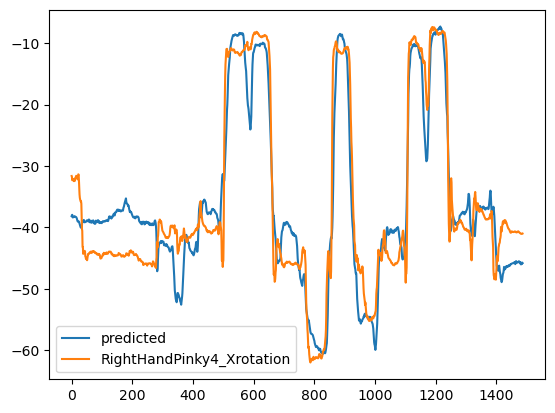

In [9]:
# here look predictions :sparkles:
y = y_train.reset_index()
plt.plot(rr.predict(x_train_scaled), label = 'predicted')
plt.plot(y.iloc[:,-1], label = y.columns[-1])
plt.legend()
plt.show()

In [10]:
out_of

{'session1>session2': {'RightHandThumb2_Xrotation': {'r2': 0.7515682046411829},
  'RightHandThumb2_Zrotation': {'r2': 0.21703785364615524},
  'RightHandThumb3_Xrotation': {'r2': 0.7423913953423907},
  'RightHandThumb4_Xrotation': {'r2': 0.763899213120506},
  'RightHandIndex2_Xrotation': {'r2': 0.8060823342957205},
  'RightHandIndex2_Zrotation': {'r2': 0.7728142946430672},
  'RightHandIndex3_Xrotation': {'r2': 0.807885685814832},
  'RightHandIndex4_Xrotation': {'r2': 0.7865347278790403},
  'RightHandMiddle2_Xrotation': {'r2': 0.7868052039265022},
  'RightHandMiddle2_Zrotation': {'r2': 0.8661535518824659},
  'RightHandMiddle3_Xrotation': {'r2': 0.6929093451745869},
  'RightHandMiddle4_Xrotation': {'r2': 0.7356692877223505},
  'RightHandRing2_Xrotation': {'r2': 0.9349146025501599},
  'RightHandRing2_Zrotation': {'r2': 0.0694828607001643},
  'RightHandRing3_Xrotation': {'r2': 0.9161072986266966},
  'RightHandRing4_Xrotation': {'r2': 0.8574466458478448},
  'RightHandPinky2_Xrotation': {'r2'